# Diffusion Convolution PDE iterative solver

In [22]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

## Physical Parameters

The following parameters define the spatial and temporal discretization of the quantum heat equation:

- `x_lb = 0`: Left boundary of the spatial domain.
- `x_rb = 1`: Right boundary of the spatial domain.
- `d = 2`: Spatial dimensionality of the problem (e.g., 2D domain).
- `n = 5`: Number of discretization points per spatial dimension. The total number of grid points is \( n^d \).
- `dt = 1e-3`: Time step size used for temporal evolution. This value determines the resolution of the simulation in time and affects the stability and accuracy of the solver.

These parameters are used to construct the quantum representation of the discretized domain, which is then encoded into qubits for simulation via quantum algorithms.


## Spatial Grid Construction

The spatial domain is discretized into a uniform grid for numerical simulation and quantum encoding. The parameters are defined as follows:

- `N = 2**n`: Total number of grid points per spatial dimension. This exponential scaling is often used to match the number of basis states representable by \( n \) qubits, i.e., \( N = 2^n \).
- `L = x_rb - x_lb`: Physical length of the domain in one dimension.
- `dx = L / N`: Spatial resolution or grid spacing.

For a 2D simulation:
- `y_lb = x_lb`, `y_ub = x_rb`: The domain is assumed to be square.
- `N_x = N`, `N_y = N`: Number of grid points in the \( x \) and \( y \) directions.

In [23]:
## Parameters
x_lb, x_rb = 0, 1
n = 4  # N = 16. Total grid points = 16^3 = 4096.
N_x = 2**n
L = x_rb - x_lb
dx = L/N_x
dt = 1e-3

## 3D Grid
xs, ys, zs = jnp.meshgrid(
    jnp.linspace(x_lb, x_rb, N_x, endpoint=False), 
    jnp.linspace(x_lb, x_rb, N_x, endpoint=False), 
    jnp.linspace(x_lb, x_rb, N_x, endpoint=False),
    indexing='ij'
)

## Diffusion Coefficient Matrix A, 
# div(A grad u) = f
A = jnp.array([
    [3.0, 1.0, 0.0], 
    [1.0, 2.0, 0.0],
    [0.0, 0.0, 3.0]
])


def spectral_eigenvalues(N, L=1.0):
    """Eigenvalues of the 1D derivative operator with periodic condition."""
    # 2j * pi * k
    k = jnp.fft.fftfreq(N, d=L/N) * 2j * jnp.pi  
    return k

## Define diffusion energy

In [24]:
@jax.vmap
@jax.vmap
@jax.vmap
def A_vec(u):
    return A@ u

@jax.vmap
@jax.vmap
@jax.vmap
def vec_dot(u, v):
    return jnp.dot(u, v)

def energy(u):
    u_h = np.fft.fftn(u)
    wave = np.fft.fftfreq(N_x, d= dx) * 2j* np.pi
    k_x, k_y, k_z  = np.meshgrid(wave, wave, wave, indexing='ij')
    u_x_h = k_x * u_h
    u_y_h = k_y * u_h
    u_z_h = k_z * u_h
    u_vec_h = np.stack([u_x_h, u_y_h, u_z_h], axis=-1)
    Au_vec_h = A_vec(u_vec_h)

    return (np.mean(vec_dot(Au_vec_h, u_vec_h))/2).real

## Source Term and Initial/Final Conditions


In [25]:
def f(x, y, z) : 
    return np.cos(2*np.pi *x) * np.sin(-2*np.pi * y) * np.cos(2*np.pi*z)
    

def u_init(x, y, z): 
    return np.cos(2*np.pi *x) * np.sin(8*np.pi *y) + 2 * np.sin(6*np.pi*y) + 3 * np.sin(10*np.pi *x) * np.cos(12 * np.pi *y)**2 + np.sin(2*np.pi*z)

## Classical Iterative Solver in Spectral Space

To simulate the time evolution of the heat equation, we implement a classical iterative solver using spectral methods. The update rule is derived from the semi-implicit time discretization of the heat equation:

$$
\frac{u^{n+1} - u^n}{\Delta t} = \mathrm{div} (A \nabla u^{n+1}) - f
$$

Rearranged as:

$$
(\mathbb{I} - \Delta t \; \mathrm{div} (A \nabla )) u^{n+1} = u^n - \Delta t f
$$

This equation is solved in Fourier space, where the Laplacian operator becomes a diagonal multiplication by \( -k^2 \). The steps are:



In [26]:
def iterative_heat(u_n, f, dt=dt): 

    u_h = jnp.fft.fftn(u_n)
    f_h = jnp.fft.fftn(f)

    RHS =  u_h - dt* f_h

    # Invert (\Id - dt \Delta)    
    wave = jnp.fft.fftfreq(N_x, d= dx) * 2j* np.pi
    k_x, k_y, k_z = jnp.meshgrid(wave, wave, wave, indexing='ij')
    diffuse_u_h = (A[0,0]*(k_x**2) + A[1, 1]*(k_y**2) + A[2, 2]*(k_z**2)
                   + 2*(A[0, 1] * k_x * k_y + A[1, 2] * k_y * k_z + A[2,0]*k_z *k_x))

    ones = jnp.ones_like(diffuse_u_h)
    u_next_h = RHS/(ones - dt* diffuse_u_h)
    
    return  jnp.fft.ifftn(u_next_h)

In [27]:
## Initialization
#u_spec = u_init(xs, ys)
#energy_spec = [energy(u_spec)]
#
#for _  in range(40):
#    u_spec = iterative_heat(u_spec, f(xs, ys), dt=dt)
#    energy_spec.append(energy(u_spec))
#
#    #u_curr = iterative_heat(u_curr, f_val, dt=dt)
#
#plt.plot(energy_spec[1:], label="energy_spec")
#plt.legend()

In [28]:

def spectralFilter(N, dt):
    d = spectral_eigenvalues(N)
    D= np.diag(d)
    eye = np.eye(N)
    Diffuse_h = (A[0,0]*np.kron(np.kron(D**2, eye), eye) + A[1, 1]*np.kron(eye, np.kron(D**2, eye)) + A[2, 2] *np.kron(eye, np.kron(eye, D**2)))
    Diffuse_h += 2*(A[0, 1]* np.kron(D, np.kron(D, eye)) + A[1, 2]* np.kron(eye, np.kron(D, D)) + A[2, 0]*np.kron(D, np.kron(eye, D)))
    op_h = np.kron(np.kron(eye, eye), eye) - dt *Diffuse_h 
    #print("Condition number of D:", np.linalg.cond(op_h))
    #m_h = np.diag( 1.0/np.diag(op_h))
    #return m_h 

    return np.linalg.inv(op_h)

def iterative_heat_FG(u_val, f_val, dt): 
    N = u_val.shape[0]
    # 1D DFT matrix
    dfmtx = jnp.fft.fft(jnp.eye(N))

    # 3D DFT Matrix via Kronecker: F x F x F
    FG = jnp.kron(jnp.kron(dfmtx, dfmtx), dfmtx)

    # Inverse 3D DFT Matrix
    dfmtx_inv = jnp.conj(dfmtx).T / N
    GF = jnp.kron(jnp.kron(dfmtx_inv, dfmtx_inv), dfmtx_inv)

    u_flatten = u_val.flatten()
    f_flatten = f_val.flatten()

    u_h = FG @ u_flatten
    f_h = FG @ f_flatten

    u_new = GF @ spectralFilter(N, dt) @ (u_h - dt * f_h)

    return u_new.reshape(N_x, N_x, N_x)



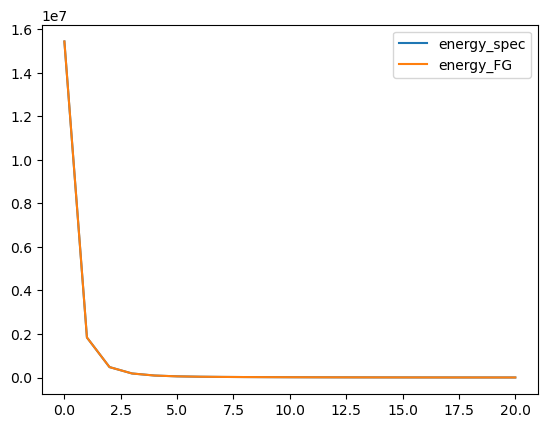

In [31]:
# Initialization
u_spec = u_init(xs, ys, zs)
u_FG = u_init(xs,ys, zs)
energy_spec = [energy(u_spec)]
energy_FG = [energy(u_FG)]

for _  in range(20):
    u_spec = iterative_heat(u_spec, f(xs, ys, zs), dt=dt)
    u_FG = iterative_heat_FG(u_FG, f(xs, ys, zs), dt=dt)
    energy_spec.append(energy(u_spec))
    energy_FG.append(energy(u_FG))

    #u_curr = iterative_heat(u_curr, f_val, dt=dt)

plt.plot(energy_spec, label="energy_spec")
plt.plot(energy_FG, label="energy_FG")
plt.legend()
#plt.savefig("diffusion_energy.png", bbox_inches="tight")

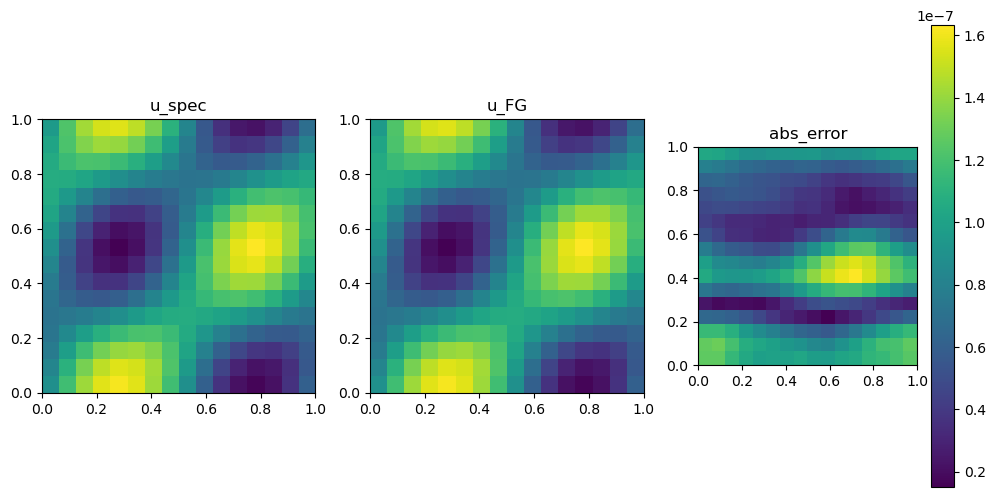

In [32]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(u_spec.real[:, :, 0], extent=[x_lb, x_rb, x_lb, x_rb], origin='lower')
plt.title("u_spec")
plt.subplot(1, 3, 2)
plt.imshow(u_FG.real[:, :, 0], extent=[x_lb, x_rb, x_lb, x_rb], origin='lower')
plt.title("u_FG")
plt.subplot(1, 3, 3)
plt.imshow(abs(u_spec-u_FG)[:, :, 0], extent=[x_lb, x_rb, x_lb, x_rb], origin='lower')
plt.title("abs_error")
plt.colorbar()